In [ ]:
import logging
import pandas as pd
import os
import random
import time, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from entsoe import EntsoePandasClient
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.query_api import QueryApi

In [ ]:
# Set up logging
logging.basicConfig(filename='entsoe.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info('Script started at %s', pd.Timestamp.now(tz='UTC'))

In [ ]:
# Set API key
API_KEY = '6276342c-e10c-4d88-8688-cb0a1cf163ca'

In [ ]:
# Define InfluxDB connection details
influxdb_url = 'http://159.89.103.242:8086'
influxdb_token = 'dfRMxqDtwyHK7vDJHelAm0WKISLvKFUrmhclvaaAoMFOHRRTGNnYkV8bXd0jR9r4arvkg3l_lWNSHyKMG0WxSg=='
influxdb_org = 'entra'
influxdb_bucket = 'entra'

In [ ]:
# Initialize the Entsoe client
client = EntsoePandasClient(api_key=API_KEY)

In [ ]:
# Create InfluxDB client
influx_client = InfluxDBClient(url=influxdb_url, token=influxdb_token, org=influxdb_org)

In [ ]:
# Create the write API
write_api = influx_client.write_api(write_options=SYNCHRONOUS)
# Instantiate the query API
query_api = QueryApi(influx_client)

In [ ]:
# Define the time period
start = pd.Timestamp('2023-07-01', tz='UTC')
end = pd.Timestamp.now(tz='UTC')

In [20]:
# Define the categories and their corresponding measurements
categories = {
    '6.1.A': 'actual_total_load',
    '6.1.B': 'day_ahead_total_load_forecast',
    '14.1.A': 'installed_generation_capacity',
    '16.1.B&C': 'actual_generation'
}

# Country codes
country_codes = ["DE_50HZ", "IT_NORD_SI", "AL", "IT_PRGP", "DE_AMPRION", "IT_ROSN", "AT", "IT_SARD", "BY", "IT_SICI",
                 "BE", "IT_SUD", "BA", "RU_KGD", "BG", "LV", "CZ_DE_SK", "LT", "HR", "LU", "CWE", "MT", "CY", "ME",
                 "CZ", "GB", "DE_AT_LU", "NL", "DE_LU", "NO_1", "DK", "NO_2", "DK_1", "NO_3", "DK_2", "NO_4", "DK_CA",
                 "NO_5", "EE", "NO", "FI", "PL_CZ", "MK", "PL", "FR", "PT", "DE", "MD", "GR", "RO", "HU", "RU", "IS",
                 "SE_1", "IE_SEM", "SE_2", "IE", "SE_3", "IT", "SE_4", "IT_SACO_AC", "RS", "IT_SACO_DC", "SK", "IT_BRNN",
                 "SI", "IT_CNOR", "GB_NIR", "IT_CSUD", "ES", "IT_FOGN", "SE", "IT_GR", "CH", "IT_MACRO_NORTH",
                 "DE_TENNET", "IT_MACRO_SOUTH", "DE_TRANSNET", "IT_MALTA", "TR", "IT_NORD", "UA", "IT_NORD_AT",
                 "UA_DOBTPP", "IT_NORD_CH", "UA_BEI", "IT_NORD_FR", "UA_IPS"]

In [21]:
sorted_country_codes = sorted(country_codes)
sorted_country_codes

['AL',
 'AT',
 'BA',
 'BE',
 'BG',
 'BY',
 'CH',
 'CWE',
 'CY',
 'CZ',
 'CZ_DE_SK',
 'DE',
 'DE_50HZ',
 'DE_AMPRION',
 'DE_AT_LU',
 'DE_LU',
 'DE_TENNET',
 'DE_TRANSNET',
 'DK',
 'DK_1',
 'DK_2',
 'DK_CA',
 'EE',
 'ES',
 'FI',
 'FR',
 'GB',
 'GB_NIR',
 'GR',
 'HR',
 'HU',
 'IE',
 'IE_SEM',
 'IS',
 'IT',
 'IT_BRNN',
 'IT_CNOR',
 'IT_CSUD',
 'IT_FOGN',
 'IT_GR',
 'IT_MACRO_NORTH',
 'IT_MACRO_SOUTH',
 'IT_MALTA',
 'IT_NORD',
 'IT_NORD_AT',
 'IT_NORD_CH',
 'IT_NORD_FR',
 'IT_NORD_SI',
 'IT_PRGP',
 'IT_ROSN',
 'IT_SACO_AC',
 'IT_SACO_DC',
 'IT_SARD',
 'IT_SICI',
 'IT_SUD',
 'LT',
 'LU',
 'LV',
 'MD',
 'ME',
 'MK',
 'MT',
 'NL',
 'NO',
 'NO_1',
 'NO_2',
 'NO_3',
 'NO_4',
 'NO_5',
 'PL',
 'PL_CZ',
 'PT',
 'RO',
 'RS',
 'RU',
 'RU_KGD',
 'SE',
 'SE_1',
 'SE_2',
 'SE_3',
 'SE_4',
 'SI',
 'SK',
 'TR',
 'UA',
 'UA_BEI',
 'UA_DOBTPP',
 'UA_IPS']

In [ ]:
#Plotting function
def plot_measurement_data(country, start, end, measurement, filename=None):
    # Format timestamps for the query string
    start_str = start.strftime('%Y-%m-%dT%H:%M:%SZ')
    end_str = end.strftime('%Y-%m-%dT%H:%M:%SZ')
    
    # Query data from InfluxDB
    query = f'from(bucket: "entra") |> range(start: {start_str}, stop: {end_str}) |> filter(fn: (r) => r["_measurement"] == "{measurement}" and r["country"] == "{country}")'
    tables = query_api.query(query)
    
    # Check if data is available
    if not tables:
        print(f"No data available for {measurement} in {country} during the specified period.")
        return
    
    # Extract data from the result
    data = []
    for table in tables:
        for record in table.records:
            data.append((record.get_field(), record.get_value(), record.get_time()))
    
    # Create a DataFrame for plotting
    df = pd.DataFrame(data, columns=['field', 'value', 'time'])
    
    # Plot the data using seaborn
    sns.set(style="darkgrid")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='time', y='value', hue='field')
    plt.title(f'{measurement} in {country}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    
    # Save the plot if filename is provided
    if filename:
        file_path = f'plot_{country}_{measurement}_{start.date()}_{end.date()}.png'
        plt.savefig(file_path)
        print(f"Plot saved as {file_path}")
    
    plt.show()


Plot saved as plot_AL_actual_total_load_2022-01-01_2023-07-24.png


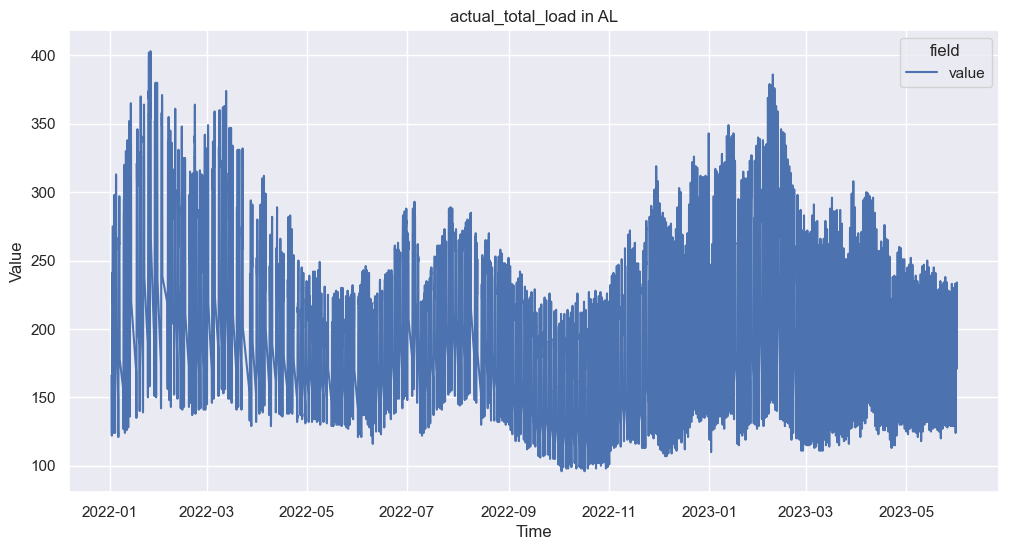

In [19]:
#Visualize data for 1 country and 1 measurement (+save the plot)
country = 'AL'
start = pd.Timestamp('2022-01-01', tz='UTC')
end = pd.Timestamp.now(tz='UTC')
measurement = 'actual_total_load'

plot_measurement_data(country, start, end, measurement, filename= 'plot')

In [ ]:
#Save all plots
start = pd.Timestamp('2022-01-01', tz='UTC')
end = pd.Timestamp.now(tz='UTC')
for country in sorted_country_codes:
    for measurement in categories.values():
        plot_measurement_data(country, start, end, measurement, filename= 'plot')     